# EURO 24 Predictions






# Table of contents 

1. [$\color{orange}{\text{Soft introduction}}$](#Q1)
    1. [On EURO competitions](#cleaning)
    2. [Making predictions, various football models](#check)   
2. [$\color{orange}{\text{Hard introduction  - Technical background   }}$](#Q2)
    1. [General statement of the learning problem](#g)
    2. [Regression and Classification](#rac)
    3. [Cross-validation](#cv)
    4. [$\color{purple}{\text{Logistic and Poisson regression}}$](#subparagraph3)     
    5. [$\color{purple}{\text{Decision Trees}}$](#subparagraph3) 
    6. [$\color{purple}{\text{Random Forests}}$](#subparagraph3)
    7. [$\color{purple}{\text{Gradient boosted trees}}$](#q3-intro)
3. [$\color{orange}{\text{ Application for EURO 24   }}$](#Q22)
    1. [$\color{purple}{\text{Formulating the problem}}$](#subparagraph3)
       1. [Choice of variables,database](#bla1)
       2. [Choice of the model ](#bla2)
       3. [Modifications to (Schauberge & Grall , 2018)](#fin0)
       4. [The "correction" ](#bla3)
    2. [$\color{purple}{\text{Coding Implementation}}$](#subparagraph3)
       1. [Data creation](#data1)
       2. [Tuning and predictions for GBT ](#hp1)
       3. [Tuning, "correction", predictions for RF ](#hp1)
       4. [Simulations for the group stages ](#hp1)
4. [$\color{orange}{\text{ Overview of results (on what to bet ?) }}$](#Q4)
5. [$\color{orange}{\text{ Literature  }}$](#lit) 
   

# Soft introduction

The UEFA European Football Championship (or simply the EURO) is a football competition held every four years, featuring 24 teams from the european continent.

For the sake of brevity,  [this wikipedia page](https://en.wikipedia.org/wiki/UEFA_Euro_2024) will serve as a further introduction. Notably the section on the "group stages" relevant.


##  Football predictions

An introduction covering various predictive models for football can be found in [this paper](https://arxiv.org/pdf/2403.07669).

# Hard introduction <a class="anchor" id="Q2"></a>

Below we give a concise formulation of the general framework of the task of predictive statistics. The two most important cases of this framework being regression and classification. In machine learning this is usually called "the supervised learning problem". Later on we will formulate our "EURO predictions problem" using this framework.  

## General Framework <a class="anchor" id="g"></a>

- Suppose we have a random vectors $$ \boldsymbol{Z}_i = \left(   Y ,  \boldsymbol{X}  \right)_i \ , \ \ \ i = 1 ,..., N  \ \  \text{ and iid } $$ with associated probability distribution $F^{ \left(   Y ,  \boldsymbol{X}  \right)}$ ( $Y$ is supposed single dimensional and $\boldsymbol{X}$ , $p$-dimensional.)

- Most of the time  $F^{ \left(   Y ,  \boldsymbol{X}  \right)} (y , \boldsymbol{x})$ is unknown, and the task to approximate it or rather to approximate $F^{ \left(   Y |  \boldsymbol{X = x}  \right)} (\boldsymbol{x})$ ,the conditional distribution of $y$ given $\boldsymbol{x}$ (sometimes called the "supervisor").

- The previous is often too difficult, to simplify we suppose that $ Y = f( \boldsymbol{X} ) $ and the goal now is to choose an $f( \boldsymbol{X} )$ such that the realizations $y =f( \boldsymbol{x} )$   "best match" the realizations of the supervisor (i.e. $f(\boldsymbol{x})$ that best matches the samples pulled from $F^{ \left(   Y |  \boldsymbol{X = x}  \right)} (y)$ ). 

- Next we define a loss function : $L = L( y - f(x))$. The "best matching" $f(\cdot)$ is the one that minimizes the **risk** (the average of the loss):
$$ R = \mathbb{E}_{Y  ,\boldsymbol{X}}  \left[  L( Y - f(\boldsymbol{X}))  \right] = \int_{\mathcal{X} ,\mathcal{Y}    } L( y - f(x)) dF^{ \left(   Y ,  \boldsymbol{X}  \right)}(y , \boldsymbol{x})$$

In other words, were we to sample a huge number of times over $\boldsymbol{Z}$ , the best $f(\cdot)$ would minimize the average loss of this huge sample.

- Developing the idea further: let $f(\cdot)  = h( \cdot , \alpha)  $  - we restrict $f$ to a parametric function $h$ . More precisely:

   - $h$ is the "model" ( linear model, random forest, etc...)
   - $\alpha \in \Lambda$ is a vector of model parameters (for example $\alpha' x$ in a linear model). $\Lambda$ is a particular restriction of the hypothesis space. Usually $\Lambda$ is partitioned into nested and exhaustive $\Lambda_s ,  \ s = 1, ... , S$ where $s$ is the degree of complexity (the polynomial degree of in a linear model for example).

    
 


---
- To evaluate the performance of $h$ it is not enough to only consider $R = R(\alpha_N)$ . Here $\alpha_N$ means the optimal model parameter obtained by "training" on $D_N$.

- We introduce the concept of **generalization error** $G_N$ . If we were to sample $D_N$ a great number of times , each time getting the optimal $\alpha_N$ choosen by the model , $G_N$ is defined as the average value of $R( \boldsymbol{\alpha})$ over $\boldsymbol{D}_N$ :

 $$G_N = \mathbb{E}_{\boldsymbol{D}_N}[ R( \boldsymbol{\alpha}_N)] $$

It is similar to the risk integral , but with an additional average over the distribution of $D_N$. 

- In practice , after choosing $h$ ,  one partitions $\Lambda$ into $\Lambda_s$ and tries to find which for which complexity parameter $s$ ( also called hyperparameter) the model $h$ has the lowest $G_N$.  See [Hastie & al, 2009 , p220](https://hastie.su.domains/Papers/ESLII.pdf) for a wonderful visualisation of $R(\alpha^s_N) , G^s_N$ for a "lasso model" with varying complexity $s$.   

- Of course, for a particular $\Lambda$ the generalization error ($G_N$) itself is unknown and needs to be approximated ($\hat{G}_N$) from a single $D_N$ available . One can take the empirical risk associated with that $\alpha_N$ as $\hat{G}_N$ , but that by definition will be low (since it minimizes that risk) and is a biased (optimisitic) estimator of $G_N$.

-  One can bypass this bias by **cross-validation** noted CV (see the next section for details) ,


-  The **final "recipe"** for choosing the model becomes: **(i)** choose $h$ , **(ii)** choose $\Lambda$ and its nested exhaustive partitions $\Lambda_s , \ s = 1 , ... ,S$ (i.e. choose the set of hyperparameters) , **(iii)** using CV find the hyperparameter $s_{min}$ for which $h$ has lowest $\hat{G}_N$, **(iv)** the final model is $Y = h( \boldsymbol{x}  , \alpha^{s_{min}}_N)$ i.e. $h$ with the optimal $\alpha_N$ from $\Lambda_{s_{min}}$.







That concludes the general statement of the learning problem. 

It roughly follows the one presented in textbooks (Vapnik, The Nature of Statistical Learning Theory), (Hastie and al. , The Elements of Statistical Learning) and (Bontempi , Statistical Foundations of Machine Learning : The Handbook) 

## Regression and Classification <a class="anchor" id="rac"></a>

**Regression** can be seen as a special case of the general case above when it is additionally assumed:

- the loss is $L = \left( y - f(x)  \right)^2$
- $Y = f(\boldsymbol{x}) + \varepsilon , \ \ \varepsilon \sim N(0, \sigma^2)  , \ \ \varepsilon \perp \boldsymbol{X}   $ . $Y$ is a deterministic function of $\boldsymbol{x}$ with a additive normally distributed noise term, independent of $\boldsymbol{X}$
- $Y$ is quantitative ($ \in \mathbb{R}$)

The first  point implies that $ f(x) = \mathbb{E}[  Y | \boldsymbol{X} = \boldsymbol{x}] $ is the minimal risk for quadratic $L$ . One then proceedes by making a choice of $h(x , \alpha)$ and of $\Lambda$ and looks for $s$ ($\Lambda_s$) for which $\hat{G}_N$ is minimal. In the regression case $\hat{G}_N$ is called **MISE** (mean integrated square error). In (Bontempi , SFoML) there is a detailed calculation of the decomposition of $\hat{G}_N$ into a variance term and bias term for regression with the choice of $L^2$.


Similary **classification** is the case when:

- $Y$ is categorical with $y \in \{ c_1 , .... , c_K \}$ categories.
- the loss is the "0-1" loss (or other losses with "cost") : $$ \text{ for } k = 1,...K , \ \ \ \left\{  L(c_k , h) = 1 \text{ if } h( \cdot , \alpha) = c_k , \ \ \ L(c_k , h) = 0  \text{ if not }  \right\}$$

Now the $\hat{G}_N$ is called the **MME** (mean misclassification error) and we repeat the "recipe" above to find the best $s$. Similary a bias,variance decomposition exists for MME, see (Bontempi , SFoML).






## Cross-validation <a class="anchor" id="cv"></a>


Suppose we have the realizations $D_N$ and have selected a model $h$ and a hypothesis space $\Lambda$ and its nested partitions $\Lambda_s$.
We wish to find the generalization error of a $s$ but we know that the empirical risk $R(\alpha^s_N)$ is a biased estimator of $G_N$.
Cross-validation (CV) is a method of getting an unbiased estimator of the generalization error $\hat{G}_N$.

In the context of the supervised learning problem ,the CV procedure can be summarized as follows (this is step (iii) from the recipe):

- for each $s \in \{1 ,..., S\}$
- divide $D_N$ into $K$ disjoint and exhaustive partitions $D_k$
- for each $k = 1 ,... , K$ train the $h$ on $D_N - D_k$ (total set without the $k$th partition) under the restriction $\alpha_N \in \Lambda_s$ and calculate the empirical risk on $D_k$
- average all the $K$ empirical risks found in the previous steps -  **that gives an unbiased estimator of $\hat{G}^s_N$**
- choose the final $s$ that has minimal  $\hat{G}^s_N$

Subpoints 1,2,3 ("inner CV-loop") represent the cross-validation prodecure itself. Subpoint 1 is the called the "outer loop" or complexity search.




## Logit regression and Poisson regression


For the sake of simplicity ,let us assume $Y$ categorical but with only two categories (i.e. binary).  The case with more than two categories is similar and can be found in the reference books.

Denote $p_1,p_2 = 1- p_1$ the associated probabilities.

**Logistic** regression supposes that $ p_1 = p_1( \boldsymbol{x} , \boldsymbol{\beta}) $ with:

$$ \ln{ \left( \dfrac{p_1}{1-p_1} \right) } =  \boldsymbol{\beta}' \boldsymbol{x}$$

The $\boldsymbol{\beta}$ coefficients are choosen such that they maximize the likelihood $$ \prod_{i:  y_i = 1} p_1( \boldsymbol{x_i} , \boldsymbol{\beta}) \prod_{i:  y = 0} \left(1-p_1( \boldsymbol{x_i} , \boldsymbol{\beta} ) \right) , i = 1,...,N  $$

Or equivalently, the maximize the associated log-likelihood.

In the context of the supervised learning formulation this is what (Vapnik, TNoSLT) calls the **density estimation** case, with:

- $L = - \ln{ p(\boldsymbol{x} ) }  $ the negative log-likelihood (*cross-entropy*)

The associated risk is the sum of log probabilities above. To be more precise we should introduce a reference to the complexity parameter $s$ and data $D_N$ like this: $ p( \boldsymbol{x} , \beta_N^s   )$. Here $s = 1 , ..., S$ could be the degree of the polynomial for example . To find the best $s$ one would use the "recipe".


---

For **Poisson** regression one takes $Y \sim \text{Poi}(\lambda)$ and supposes $\lambda =  \lambda( \boldsymbol{x} , \boldsymbol{\beta} )$ with:

$$ \ln{\lambda} = \boldsymbol{\beta}' \boldsymbol{x}  \iff \lambda = e^{\boldsymbol{\beta}' \boldsymbol{x}}    $$

The log-likelihood (mod an unimportant additive term) of $N$ iid Poissons is then $$   \sum^N_{i=1} y_i \boldsymbol{\beta}' \boldsymbol{x}_i - e^{\boldsymbol{\beta}' \boldsymbol{x}_i} , \ \  i = 1,...,N    $$

whose gradient needs to be set to 0 (wrt. $\beta_i$) , and those equations solved to get the optimal coeffs.


Again, with $L = - \ln{ p(\boldsymbol{x}, \beta_N^s ) }  $ this can be considered as an density estimation case of the general learning case.




## Decision trees

Suppose we have a $D_N$ with $\text{dim}(\boldsymbol{x})= p , \ y \in \mathbb{R}  $.

**Decision trees** partition the $p$ space of the features into $R_1 ,...,R_m , ... , R_M$ simple rectangles (simple means that all the rectangles must be constructed by drawing vertical lines that start from the main coordinate axis).


For example in the figure below ($p=2$), the all of the partitions to the left are simple while the right contains some that are not simple.

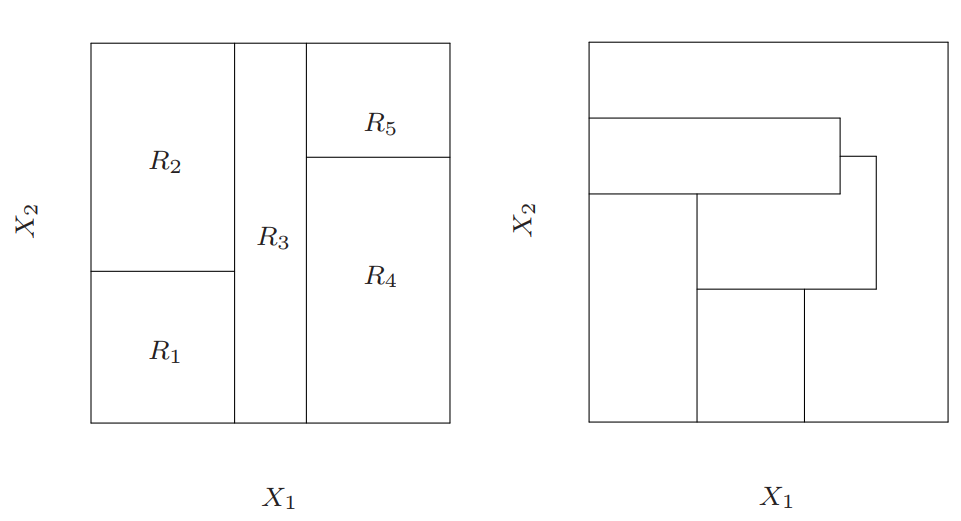


We take the $h$ function to be:

$$ h(\boldsymbol{x} ,  (\boldsymbol{c} , \boldsymbol{R})'  ) =  \sum^M_{m=1} c_m \mathbb{I}[ \boldsymbol{x} \in R_m]  $$

The parameter vector $(\boldsymbol{c} , \boldsymbol{R})'$ is all the regions and $\boldsymbol{c}$ real constants associated for those regions. For a quadratic loss and for fixed regions $R_m$ the best choice of $c_m$ is :

$$ \hat{c}_m = \mathbb{E}[   y( \boldsymbol{x}_i) : \boldsymbol{x}_i \in R_m  ]   $$

the average of $y$ in that region.


---

Usually it is difficult to directly find the best partition and best constants at the same time.

(Hastie & al. ,2009) suggest the following *greedy* startegy:

- Split the $p$-space into two simple regions by drawing a single line somewhere on the axis of the $j$th  $$ R_1(j,s) = \{ \boldsymbol{x} : x_j \leq s  \} , \ \ \ R_2(j,s) = \{ \boldsymbol{x} : x_j > s  \}  $$

- do a search on the $(j,s)$ grid and find $$ (j^{*} ,s^{*}) = \underset{(j,s)}{\text{min}} \left[  \hat{c}_1 + \hat{c}_2 \right] $$

- once $(j^{*} ,s^{*})$ are found , divide the data into $D_{N_1 , R_1} , D_{N_2 , R_2}  $ and repeat the procedure above on those two regions. Keep doing the above until some desired limit (ex: five times).


---

The splitting of the regions is visualized as a "tree": 

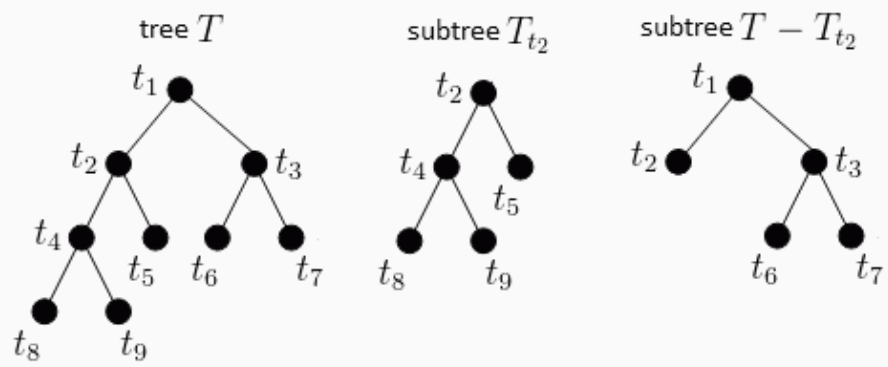

Usually a fully "grown" tree (found by applying the greedy search above five times for example) will tend to overfit the data, and one does a **complexity search** ("cost complexity pruning") to select the "best" subtree $T - \sum_i T_{t_i}$ (Hastie & al. ,2009).





### Decision trees for classification


The above decision trees were related to regression. Classification trees are essentially the same but with a different choice of loss function. For each region instead of $\hat{c}_m$ we take $\hat{p}_{mk}$:

$$ \hat{p}_{mk} = \dfrac{1}{N_m} \sum_{ \boldsymbol{x}_i \in R_m} \mathbb{I}[ y_i = k]   $$

($k$ being the $k$th category of $y$)

For each region we choose $k(m) =  \underset{k}{\text{argmax}} \left( \hat{p}_{mk} \right) $ , the majority class, as the final classification rule.

The different possible loss functions are (Hastie & al. ,2009):

- Misclassification error
- Gini index
- Cross-entropy





## Random Forests <a name="subparagraph3"></a>

Decision trees on their own are weak learners. The solution to take many different decision trees ,make them as uncorrelated as possible and then average them - this reduces the variance. If one does that (the exact procedure will be presented) the average of those low correlated trees: 
$$ f_{rf} (\boldsymbol{x})= \frac{1}{B}\sum^B_{b=1} T_b( \boldsymbol{x}) $$
is called a random forest. Suppose we have $B$ trees with negligable bias and comparable variance $\sigma^2$ and mutual correlation $\rho$. It can be shown that $$ \text{Var}( f_{rf}(\boldsymbol{x}))  = \rho \sigma^2 +  \frac{1-\rho}{B} \sigma^2  $$  By either increasing the number of trees or by decreasing the mutual correlation we reduce the total variance.

Here is the **random forest algorithm** (Hastie & al. ,2009) :


1. For $b = 1 , ..., B$ :

    (a) Draw a bootstrap sample $D^{*}_N$ of size $N$ from the training data.

    (b) Grow a random-forest tree $T_b$ to the bootstrapped data, by recursively repeating the following steps for each terminal node of the tree, until the minimum node size $n_{\text{min}}$ is reached.
    
      (i) Select $m$ variables at random from the $p$ variables.
        
      (ii) Pick the best variable/split-point among the $m$.
        
      (iii) Split the node into two daughter nodes.

2. Output the ensemble of trees $\{T_b\}_{1}^{B}$.

To make a prediction at a new point $\boldsymbol{x}$:

for **regression**: 
$$ \hat{f}_{rf} (\boldsymbol{x})= \frac{1}{B}\sum^B_{b=1} T_b( \boldsymbol{x}) $$

for **classification**: Let $\hat{C}_b(\boldsymbol{x})$ be the class prediction of the $b$-th random-forest tree. Then 
$$ \hat{C}_{\text{rf}}^B(\boldsymbol{x}) = \text{majority vote} \{ \hat{C}_b(\boldsymbol{x}) \}_{1}^{B} $$

    

Random forests are usually easy to "tune" since they have a build-in error called out-of-bag error (oob). The oob error converges to $K=N$-cross validation (leave-one-out CV) $\hat{G}_N$,  when $B \rightarrow \infty$.

They also have a built-in variable importance ranking system ;more details will be given in the coding section.

## Gradient boosted trees

Let us call:

$$ \Theta = (\boldsymbol{c} , \boldsymbol{R})  $$

the $J+J$ vector associated to decision tree problem presented earlier.

A **boosted tree** model is defined as:

$$   f_M( \boldsymbol{x}) =  \sum^M_{m=1} T(  \boldsymbol{x} ; \Theta_m ) $$

where $ T(  \boldsymbol{x} ; \Theta_m )$ are trees with the region and constants $\Theta_m$

Estimations for those $\Theta_m$ ( $\hat{\Theta}_m$) are found with the *forward additive algorithm* where at each step $m$ one solves:

$$ \hat{\Theta}_m = \underset{\Theta_m}{\text{argmin}} \sum^N_{i=1} L \left( y_i  , f_{m-1}( \boldsymbol{x_i}) + T(\boldsymbol{x_i} ; \Theta_m )  \right) $$

i.e. solves $\Theta_m$ (now the $J_m + J_m$ vector of regions and constants) given the current model $f_{m-1}(\boldsymbol{x})$.


The forward additive algorithm, aswell as the general framework for boosting, is in (Hastie & al. ,2009).

---

**Gradient boosted trees** is the particular case of the above where one assumes a differentiable loss function and reduces the $\hat{\Theta}_m$ problem to numerical optimization (which can then be solved with familiar methods). The full *gradient boosting trees algorithm* can be found in (Hastie & al. ,2009); we will not present it here.








# Application for EURO 24 <a name="Q22"></a>





 

## Formulating the problem<a name="bla"></a>


We will be attempting to answer three questions:


### <span style="color: orange;"><b>(1) Given a match, what is the predicted number of goals for each team?</b></span>

### <span style="color: orange;"><b>(2) What is the most probable group stage finish?</b></span>











In the context of the learning process:

---
**The first one** is a *regression problem* formulated as $ y = f( \boldsymbol{x} ) + \varepsilon $ , with :

- $ y \in \mathbb{R}^{+} $ -   a positive continous real ; the number of goals of **one team** in a particular match in normal time (so not the total number of goals, and not the goals in extra time/penalties) 

- the predictors $ \boldsymbol{x}$ ( $p$ dimensional , possibly containing both continuous and categorical elements)

- $\varepsilon \sim N( 0 , \sigma^2)$ (normal , centered , homoscedastic)

We take the $L^2$ risk function , and after choosing the "model type" (eg: neural network, lasso) , look for hyperparameters which minimize the corresponding generalization error approximation $\hat{G}_N$ (we usually find it by l-o-o cross validation).

**Some clarifications:** Say there are two teams playing $A$ and $B$ , both with realizations of the predictors $\boldsymbol{x}_A$ , $\boldsymbol{x}_B$. Then: $y_A$ gives the number of goals $A$ scores , and $y_B$ gives the number of goals $B$ scores. The total number of goals is $y_A + y_B$. The model is a function of $\text{dim}(\boldsymbol{x}) = p $ variables. Note that in this setup the number of goals $A$ scores is supposed independent of the opponent $B$ and vice-versa. This is similar the approach adopted in (Schauberge & Grall , 2018) in their paper on Random Forests and football world cup predictions. Here they assumed no "independence" on the opponent but rather made $y_A = y_A(\boldsymbol{x}_A , \boldsymbol{x}_B) = y_B ( \boldsymbol{x}_B , \boldsymbol{x}_A) $. In other words they trained on $2 \times N$ samples , creating two copies of each match with the home and away teams and stats inverted; in that way there is only one response $y$ - the number of goals the home teams scores.  



---



**The second question** is essentially a *classification problem* with:

- $ y \in \{ 1,2,3  \} $  - a categorical response with $1,2,3$ being "win, draw , lose".
- the predictors $\boldsymbol{x}_A , \boldsymbol{x}_B$ - same as before , but now the probabilites of $y$ must be functions of both teams.

Here we could be working with the *cross-entropy* (negative log-likelihood) loss function , after choosing the model, we "tune" that model (hyperparameter search) so that the generalization error approximation is minimized (now it is called the misclassification error).

Given our data the model should provide us with $\frac{1}{2} \times 3 \times (24 \times 23) = 828 $ values of probabilities, i.e. the win,draw,lose probabilites for each possible combination of encounters of teams (there are $24$ total teams). *With these probabilites known , it is possible to calculate the exact probability of any event in the competition*. This might be too difficult (eg: like the solitaire example presented in class) ; Monte Carlo simulations offer an easier alternative (we will in fact use them). 

To be clear: given team $A$ and team $B$ for all probabilities (win,draw,lose) we assume $P(y_{w,l,d}) =  P( \boldsymbol{x}_A, \boldsymbol{x}_B) =  P( \boldsymbol{x}_B, \boldsymbol{x}_A)$ (symmetric function of both teams). Given that FIFA conventions tend to put the stronger team as the home team, there could be a potential bias in the training data, i.e. our model would favor the home team. Mathematically said :the argument symmetry above is violated ; (Schauberge & Grall , 2018) give a "symmetry correction" (more on that later) which we will implement to fix this bias.






### Choice of database,varibles  <a name="bla1"></a>

Before discussing the choice of model , let us first discuss the possible choice of variables (i.e. the covariates or "$ \boldsymbol{x}$") .


---

It is important to realize that **"on-field"** variables (eg: the % possession , no. of dribbles... ) **are unknown** before a given match and therefore are not avaliable to be used for predictions. As a particular match progresses , these variables become more and more "revealed"; said differently it is possible to approximate and then use them only in a "live" setting. 

We will not pursue this option - we stick with the "off-field" variables. 

(a discussion of the most important "on-field" covariates can be found in (Schauberger et al. ,2017.).

---


**The "off-field"** variables are the ones known before the match, for example these include: the current form of the teams, the ranking of the teams, home advantage, economic power of the associated countries ,etc...

Here it seems like we have a lot of choice, but as it turns out most of it is "irrelevant". 

Using the built-in variable importance of random forests, it was shown (Groll et al.,2019) that the most important ones are :

- the ranking (both FIFA ranking, the ELO ranking and a "custom" Poisson ranking)
- bookmaker odds
- average age of the squad
- number of players playing abroad
- GDP of countries

(with "the ranking" and "bookmaker odds" dominating with quite a margin.)

The importance of the rest of the variables is negligable (at least according this metric).

**Note:** in the paper above a new performance metric is introduced something called "Poisson ranking". In a nutshell : some sort of "Poisson" model is applied to the data first , from which a new ranking system is constructed ("a new ELO"). The authors refer to the random forest with this additional ranking covariate as a *hybrid random forest*. 









### <span style="color: orange;">So, what variables to take ?</span>

Lead by the results of the paper above (and having simplicity in mind) , we take:  

- **ELO ranking** (not the FIFA ranking)
- **age of the squad**
  
Bookmaker odds we will not consider since: (i) it is difficult to find all the odds from all the previous competitions, (ii) the point of our model is to "beat the house".  "Number of players playing abroad" is also too time consuming to create and we will also skip it.



To add some originality , we also take the following:

- **height of the squad**
- **Knockout ?** : a categorical variable (0,1) indicating if the match is in the knockout phase or the group phase. Reasoning: teams play differently in knockout phases (it favors weaker teams).
- **Historical score** :   $+1$ point if the team won EURO or WORLD CUP , $ +0.5 $ if the team reached the finals of those two competitions. We will consider this score from 1976 and upwards
- **Top manager ?** : A three-way categorical variable $\{ 0,1,2  \} $ indicating the quality of the manager. If $0$ the manager has not managed a top10 country or in the top5 leagues, if $1$ the manager has managed a top10 country or a top5 league team, $2$ the manager has won trophies for a top10 country or for a top5 league team.






### <span style="color: orange;">What database to take ?</span>


It is important to note that **before August, 2018 the FIFA rankings were flawed** (including WC '18). 


Essentially,end of summer '18 FIFA switched from an outdated ranking system to a more robust "ELO-like" system. The exact flaws can be seen in the same paper (Groll et al.,2019 , p13). As an amusing fact , at a certain point in time Belgium was ranked number one by this flawed system. 

To have a better training set, one would need recalculate the rankings of the old competitions (either with the new Elo, or with the "poisson elo") . Fortunately this has been done on the website https://www.eloratings.net/ ; we will use those **ELO rankings**.

---

Another thing to note are FIFA's rules on penalties and "golden", "silver" goals. For the EURO and World Cup, penalties have only been introduced in 1976 and 1982 respectively. The golden,silver goals were enforced from 1992 to (and including) 2004. Since we plan on making models for both extra-time and penalties (this is to add some originiality, see below)  **we limit our data to**:


- <span style="color: orange;"> **Normal time, extra time**</span>:
    - Every EURO since and including 2008 

- <span style="color: orange;"> **Penalties**</span>:
    - Every world cup since and including 1982
    - Every EURO since and including 1976 
 











## Choice of the model (and of assumptions)  <a name="bla2"></a>

As was foreshadowed in the technical introduction, we choose **Random Forests (RF)** and **Gradient boosted trees (GBT)** as the two models, very much inline with the papers of Groll, Schauberge. (So in particular we skip any "Poisson"-like glm and logit regression models).

---

A **summary** of their (RF,GBT) "practical" properties:

Both of them are "out-of-shelf" i.e. robust, applicable to a wide range of problems and requiring little to no data preprocessing. Both have powerful R libraries and can be "tuned" in a few lines of code. Furthermore, random forests, on top of having few important hyperparameters , can be tuned with oob errors (as opposed to loo cross validation) , leading to a substantial increase in speed. Gradient boosted trees have more hyperparameters (about 7) which need to be carefully tuned , as some of them are strongly interacting. Also they don't have built-in errors. The exact tuning strategies and their code are given below.

---

**The first question** will be answered using gradient boosting trees and using the **independence** assumption (we are working with 6 variables instead of 12, and don't need a symmetry "correction"). This will allow for all the computing to be focused on tuning the GBT. Usually it is expected that GBT outperforms RF (see "no free lunch")  ,we may say that we are getting a more accurate prediction of the expected goals in exchange for more computing time.


Later the expected goals can be used as the rate parameters for a simple poisson model $$ G(A) = \text{(no. of goals by A)} \sim \text{Poi}(\lambda_A) , \ \  \lambda = \text{ "GBM prediction of no. goals"}$$ (this assumes another type of independence - that the goals of team $A$ are independent of previous goals of team $A$). $G(A)$ gives us the probabilites of the exact number of goals of $A$ . Similar can be done for $G(B)$ leading to the probabilities of all possible scores (they are the products of $P(G(A=i)) \times P(G(B = j))  $ . Similarly the sum of goals scored follows $\text{Poi}(\lambda_A) + \text{Poi}(\lambda_B) \sim \text{Poi}(\lambda_A + \lambda_B) $.


---


**The second question** we will answer using RF. The reasoning : we are working with $12$- variables ($A,B$ combined) the tuning process will be faster and the symmetry correction will be faster too. Then the results will be simulated according : (a) to the probabilities found (RF) , (b) the structure of the tournament itself , leading to the probabilities of being the winner for each team. Another remark : for each simulated match one may simulate the exact result using the above in that way a "goal difference" can be used for the group qualification process.
















## Modifications to (Schauberge & Grall , 2018)


So far, what sets this project apart from being a complete replica of (Schauberge & Grall , 2018) are:
- the use of different covariates 
- slightly different questions (they try to find the probality of being the winner for each country)
- the use of GBT instead of RF for Q1



We propose another two modifications:

- **probabilities of extra time results**: in the literature papers , the case of a potential draw in the knockout rounds was not addressed. One can suppose the authors used normal time probabilities ;of course extra time is different from normal time and should have its own model. This implies retraining both Q1 (GBT) and Q2 (RF) on an "extra time" dataset.   
- **penalties**:  in the case of a draw in extra time , we need to take into account penalties; this implies a third training set. Q1 (GBT) we will take to be the expected number of penalties scored by $A,B$ , and Q2 (RF) will be the probability of winning/losing. As a bonus we will consider **goalkeeper heights** as another covariate for the penalties (more on that later).


**In short**, the "modifications" are equivalent to asking the question:

### <span style="color: orange;"><b>(3) For any knockout match, what are the probabilities associated with extra time and penalties?</b></span>


## The "symmetry correction"<a name="bla3"></a>

For world cups and EUROs ,FIFA has a convention where the stronger team (ranking-wise) gets to be the home team. Since we are training on the previous EURO matches, that could lead to a potential home team bias in the predictions.

Here is the symmetry correction proposed in the paper:

- create $T$ versions of the training sets where $\boldsymbol{x}_{A,i} , \boldsymbol{x}_{B,i}  , \  i = 1 , ... ,N  $ are exchanged randomly (for each row :a coin is flipped to decide if we exchange the covariates $A$ with the covariates $B$ ; this will be implemented in code in the next section).
- train a RF on each copy $T$ (giving $T$ RF models)
- predict these $T$ RFs on :  (i) the normal test database ,  (ii) the inverted test database ( $A \leftrightarrow B$ for each row)
- take the total average of these predictions as the final prediction ( sum all predictions and divide by $2T$)

# Coding Implementation <a name="hp3"></a>

A rough summary of the previous chapter, and of what we need to do:

- we are tasked with answering Q1,Q2,Q3
- we gather data from the internet to include the 5 covariates mentioned above, and form three datasets: **normal , extra , pen** (to set us apart from Groll and al. who only used normal).
- for Q1 and Q3 we use (GBT) and tune it to the normal,extra training sets. This gives us a prediction of the number of goals in normal,extra for each team ($A,B$). These expected goals will be used as the rate parameter in a poisson model $\text{Poi}(\lambda)$ enabling us to have the distribution of the exact scores.
- for Q2 and Q3 we use (RF) , we tune it to the three datasets and apply the "symmetry correction" to all three ;the predictions - the classification probabilities are functions of 10 covariates (4 covariates for pens).
- finally (to fully answer Q2), for each group we run simulations  $S = 10^4$ times. This determines the empirical probabilities of the group finishes. We will also inculde the most probable goal difference for each group finish (using the rates from Q1).

More details will be given later.
  

## Creating the data

For the creation of the training sets we used:

- the results from: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017
- ELO rankings from: https://www.eloratings.net/
- the age and height from : https://www.national-football-teams.com/
- manager , history scores from wikipedia

In [2]:
# set working directory to desktop
#setwd("C:\\Users\\User\\Desktop")


In [15]:
# here is an overview of the training data

normal_train <- read.csv( "normal_train.csv")
extra_train <- read.csv( "ExtraTime_train.csv")
penalty_train <-   read.csv("all_pens_withElo_andKeeperHeight.csv")   

View(normal_train)
#print(extra_train)
#print(penalty_train)



X,home_team,home_score,ELO_A,Age_A,Height_A,History_A,Manager_A,away_team,away_score,ELO_B,Age_B,Height_B,History_B,Manager_B,knockout
<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>
1,Portugal,2,1878,26.5,180,0.5,2,Turkey,0,1815,25.0,181,0.0,0,0
2,Switzerland,0,1808,25.5,184,0.0,0,Czech Republic,1,1945,26.4,184,1.5,0,0
3,Austria,0,1598,25.1,184,0.0,0,Croatia,1,1895,26.8,184,0.0,0,0
4,Germany,2,1944,26.0,184,5.5,0,Poland,0,1782,24.7,182,0.0,0,0
5,Netherlands,3,1948,27.1,183,1.0,0,Italy,0,2032,27.9,182,3.0,2,0
6,Romania,0,1911,26.1,182,0.0,0,France,0,2013,26.4,182,2.5,1,0
7,Greece,0,1836,26.9,185,1.0,2,Sweden,2,1799,26.5,184,0.0,0,0
8,Spain,4,1964,25.3,180,0.5,2,Russia,1,1788,25.2,181,0.0,2,0
9,Czech Republic,1,1945,26.4,184,1.5,0,Portugal,3,1878,26.5,180,0.5,2,0


In [17]:
### here is the testing data (the EURO24 matches). Note: the penalty_test only includes matches from a hypothetical 
#round of 16 (see the .pdf for details)



Normal_and_Extra_test <- read.csv( "EURO2024_test.csv")

penalty_test <- read.csv("EURO 24 pens_test.csv")   


View(Normal_and_Extra_test)
View(penalty_test)



Country,ELO_A,Age_A,Height_A,History_A,Manager_A,CountryA,ELO_B,Age_B,Height_B,History_B,Manager_B,knockout
<chr>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<int>,<dbl>,<int>,<dbl>,<int>,<int>
Germany,1921,28.4,184,7.0,2,Scotland,1776,27.5,183,0.0,0,0
Hungary,1842,26.7,183,0.0,0,Switzerland,1804,28.2,182,0.0,0,0
Spain,2019,26.9,182,3.0,1,Croatia,1953,27.7,185,0.5,0,0
Italy,1956,26.3,185,4.5,2,Albania,1613,26.6,182,0.0,0,0
Slovenia,1739,25.8,184,0.0,0,Denmark,1822,26.8,184,1.0,0,0
Serbia,1788,27.2,185,0.0,0,England,1999,26.6,182,0.5,0,0
Poland,1721,27.9,184,0.0,0,Netherlands,1968,26.7,184,2.5,1,0
Austria,1857,26.0,182,0.0,2,France,2085,26.1,184,4.0,2,0
Romania,1664,26.9,182,0.0,0,Ukraine,1863,25.1,182,0.0,0,0


Country,ELO,KeeperHeight
<chr>,<int>,<int>
Croatia,1953,188
Hungary,1842,191
Germany,1921,193
Slovenia,1739,188
Portugal,2013,186
Denmark,1822,189
France,2085,191
Ukraine,1863,191
Belgium,1986,200


## Question 1 with xgboost() <a name="hp1"></a>

In [18]:
# Note: this project was done in jupyter notebook using a R kernel


# for Q1, the searching procedure (for two data sets: normal, extra) will be done with the function xgboost() from the library(xgboost) 
#we will be using library(caret) to avoid manually coding cross-validation procedures


In [25]:

# first one are the normal time scores 
# second are the countries in EURO24  

GBT_normal <- read.csv( "GBT_normal_train.csv")


GBT_test <- read.csv("EURO 2024 - Sheet1.csv")

#View(GBT_normal)
View(GBT_test)

Country,ELO,Age,Height,History,Manager
<chr>,<int>,<dbl>,<int>,<dbl>,<int>
Germany,1921,28.4,184,7.0,2
Scotland,1776,27.5,183,0.0,0
Hungary,1842,26.7,183,0.0,0
Switzerland,1804,28.2,182,0.0,0
Spain,2019,26.9,182,3.0,1
Croatia,1953,27.7,185,0.5,0
Italy,1956,26.3,185,4.5,2
Albania,1613,26.6,182,0.0,0
Slovenia,1739,25.8,184,0.0,0


In [20]:
# as summarized in Bartz et al. (2023)
#these are the recommended ranges and heuristics for the hyper.params for xgboost()

# nrounds :  100 to 10^4 (hundreds to thousands)
# eta (learning rate, shrinkage) :  take <0.1 , ex: 2^−10,2^-9,..., 0.1 
# lambda (regularization) : 2^-10 to 2^10 (powers of)
# alpha (similar to lambda) : -||-
# subsample :  0.5  , or 0.5 to 1
# colsaple_bytree : 0.1 , 0.2 , ... 1
# gamma (controls no. of splits) : 2^-10 , 2^-9 , ... , 2^10
# maxdepth: 4 to 10
# min_child_weight : 2^-10 , 2^-9 , ... , 2^10


### Additionally there are the known interactions between:

# nrounds <--> eta                   (A)
# maxdepth <--> min_child_weight     (B)



### Searching for all of these parameters is VERY computationally expensive
# (be it exhaustive, random or bayesian optimisation)


#We adopt this strategy :


### GREEDY ON THE INTERACTIONS (inspired by https://shorturl.at/luLM5)  
# Do an exhaustive search on (A) while fixing the other parameters to default and find the optimal values for (A)
# fix those optimal (A) values and do an exhaustive search for (B)


In [14]:



# for the ranges of (A) we take
## nrounds = seq(100, 1000, by = 100) 
## eta = c(2^seq(-10, -3), 0.1)

# then for (B) (after getting the optimal nrounds, eta)
##   max_depth = seq(4,10)
##   min_child_weight = 2^seq(-3,3)






set.seed(1)

library(xgboost)
library(caret)


#using caret() makes cross validational searches easy; we just specify : the grid, the number of CV-folds ( trainControl ) 
#then we call train( method = "xgbTree" ,grid, trainControl , data =... )
# this does a search and gives the hyper.params with the lowest generalization error 

# Measure the time
start_time <- Sys.time()

greedy_grid_A <- expand.grid(
  nrounds = seq(100, 1000, by = 100),
  max_depth = 6, 
  eta = c(2^seq(-10, -3), 0.1),
  gamma = 2^0, 
  colsample_bytree = 1, 
  min_child_weight = 1, 
  subsample = 0.5 
)



# specify 10-CV as the validation method
my_train_control <- trainControl(method = "cv", number = 10)

 
#do an exhaustive search for this small grid A
fit <- train(
  score ~ .,
  data = GBT_normal,
  method = "xgbTree", # we select our method, gradient boosted trees
  trControl = my_train_control, # the 10-CV specified above
  tuneGrid = greedy_grid_A, # the grid
  verbose = FALSE,
     verbosity = 0
)

# Measure end time
end_time <- Sys.time()

cat("Time taken:", end_time - start_time, "\n")
print(fit)

#took 9min

Warning message:
"package 'xgboost' was built under R version 4.3.3"
Warning message:
"package 'caret' was built under R version 4.3.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.3.3"

Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin


Loading required package: lattice



Time taken: 9.360466 
eXtreme Gradient Boosting 

328 samples
  5 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 296, 295, 295, 294, 296, 296, ... 
Resampling results across tuning parameters:

  eta           nrounds  RMSE      Rsquared    MAE      
  0.0009765625   100     1.297329  0.10135506  1.0037123
  0.0009765625   200     1.260841  0.09605431  0.9741618
  0.0009765625   300     1.230078  0.09564102  0.9470407
  0.0009765625   400     1.204282  0.09493430  0.9229276
  0.0009765625   500     1.183193  0.09290116  0.9052090
  0.0009765625   600     1.165820  0.09081712  0.8940625
  0.0009765625   700     1.151318  0.08994960  0.8875306
  0.0009765625   800     1.139464  0.08929902  0.8829324
  0.0009765625   900     1.129947  0.08885585  0.8800124
  0.0009765625  1000     1.122317  0.08870182  0.8788458
  0.0019531250   100     1.261545  0.09330604  0.9747132
  0.0019531250   200     1.204085  0.09467930  0.9222713
  0.0019531250   30

In [ ]:


#nrounds = 900, max_depth = 6, eta = 0.001953125, gamma = 1, colsample_bytree = 1, min_child_weight = 1 and subsample = 0.5.

#the above are the optimal (A)


## Now we fix the optimal (A) , and search (B) 

# maxdepth: 4 to 10
# min_child_weight : 2^-10 , 2^-9 , ... , 2^10


# same procedure as before , different grid

# the code below took some 30min to run on my 4gb RAM laptop

greedy_grid_B <- expand.grid(
  nrounds = 900,
  max_depth = seq(4,10), 
  eta =  0.001953125,
  gamma = 1, 
  colsample_bytree = 1, 
  min_child_weight = 2^seq(-3,3), 
  subsample = 0.5 
)


my_train_control <- trainControl(method = "cv", number = 10)

 

fit <- train(
  score ~ .,
  data = GBT_normal,
  method = "xgbTree", 
  trControl = my_train_control, 
  tuneGrid = greedy_grid_B, 
  verbose = FALSE,
     verbosity = 0
)

print(fit)


In [24]:

## Result:
## nrounds = 900, max_depth = 4, eta = 0.001953125, gamma = 1, colsample_bytree = 1, min_child_weight = 8 and subsample = 0.5.
## These are the optimal hyper.params according to this greedy strategy

set.seed(1)


library(xgboost)

#now we train the model on the normal time data using xgboost()


# our optimal params
params <- list(
  max_depth = 4,
  eta = 0.001953125,
  gamma = 1,
  colsample_bytree = 1,
  min_child_weight = 8,
  subsample = 0.5
)

# call the xgboost() function ( notice this time there is no caret() involved )
model <- xgboost(data = as.matrix(GBT_normal[, -1]),  
                 label = GBT_normal$score, 
                 nrounds = 900,
                 params = params,
                 verbose = 0)

Warning message:
"package 'xgboost' was built under R version 4.3.3"


In [38]:

#finally predict the rates on the test data 
rates <- predict(model, newdata = as.matrix(GBT_test[ , -1]))

lambda_countries <- cbind( rates , GBT_test )

# Round the "rates" column to two decimals
lambda_countries$rates <- round(lambda_countries$rates, 2)

lambda_countries <- lambda_countries[order(-lambda_countries$rates), ]


#write.csv( lambda_countries , "lambda_countries.csv")

View(lambda_countries)

,rates,Country,ELO,Age,Height,History,Manager
,<dbl>,<chr>,<int>,<dbl>,<int>,<dbl>,<int>
6,1.56,Croatia,1953,27.7,185,0.5,0
17,1.48,Belgium,1986,26.0,184,0.0,2
14,1.37,Netherlands,1968,26.7,184,2.5,1
16,1.36,France,2085,26.1,184,4.0,2
7,1.31,Italy,1956,26.3,185,4.5,2
1,1.12,Germany,1921,28.4,184,7.0,2
12,1.11,England,1999,26.6,182,0.5,0
23,1.09,Portugal,2013,26.8,181,1.5,1
15,0.92,Austria,1857,26.0,182,0.0,2


Now that all the rates $$\lambda_i \ \  ,\forall i \in \text{ "countries" }$$ are given , we know exactly the probabilities of events involving scores , they are given by the corresponding $ \text{Poi}(\lambda_i)$ distributions. We will present some popular probabilities (converted into odds) (over 2.5 goals, both teams to score , etc...) for the group stage matches in the "presentation of results" section.

#  --> The same procedure was done for extra time <--

## Question 2 with randomForest() <a name="hp1"></a>



In [ ]:
# Note: this project was done in jupyter notebook using a R kernel


# for Q2,  the entire procedure will be done with the function randomForest() from the library(randomForest)
# we won't be needing any training libraries like library(caret) (or manually coding cross-validation procedures),  
# since we are using the built in out-of-bag error for tuning 

#install.packages("randomForest")



# Usually the default forest is a decent model



### Relevant hyperparameters, searching strategy

For the randomForest() function the relevant parameters are: 

- **Number of trees** :  $ntree$  ---> the number of trees
- **Tree depth** : controlled by:
    - $maxnodes$  --->depth of each tree
    - $nodesize$ ---> the minimum node size
- **Features** : $mtry$ ---> the number of features to select
- **Subsample size** : $samplesize$ ---> samples to take from data

In general, it seems best to take the number of trees as high as your computer allows, and not to tune both the subsample size and tree depth, i.e. just tuning one of them while keeping the other fixed (Scornet, 2017).

---

As for the **search strategy**, we will do a **greedy** search using the **oob error** as an estimate of the generalization error (in our case it is the misclassification error).

More precisely:
- first we will do an oob error search for ntrees - while keeping the other parameters to default , we look for an $ntree$ for which the oob error stabilizes (call that number ntree_optimal, $n_0$ ). In principal more trees is always better, but after some point the computational time outweighs the error reduction.
  
- after that ,as was suggested by the above reference we tune the tree depth. That is:  we fix $n_0$ , use the default sample size (all $N$ samples of the data) and tune $maxnodes$ from say $ \{ 5,6,7,8, \text{default} \}$ (default being no limit). By "tune" , again we mean looking for the parameter with the smallest value of oob error.

### HP search code

In [ ]:


d <- read.csv("RF_normal_train.csv")

#View(d)

# this is needed for classification with RF
d$result <- as.factor(d$result)



In [22]:
set.seed(123)


library(randomForest)


start_time <- Sys.time()

#######
n_min <- 100    
n_max <- 500  
oob <- c() 
#######


for (i in n_min:n_max) {
  
  # train rf
  rf_model <- randomForest(result ~ ., data = d, ntree = i)
  
  # attatch to empty container
  oob <- c(oob, rf_model$err.rate[i, "OOB"])
  
}


end_time <- Sys.time()


min_error <- min(oob)
optimal_ntree <- which(oob == min_error) + n_min - 1


cat("Minimum OOB error:", min_error, "\n")
cat("Optimal ntree:", optimal_ntree, "\n")
cat("Time taken:", end_time - start_time, "\n")




## Result: let us take 255 trees

Warning message:
"package 'randomForest' was built under R version 4.3.3"
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.



Minimum OOB error: 0.3536585 
Optimal ntree: 120 129 173 181 255 275 398 
Time taken: 28.63326 


In [8]:
set.seed(123)



## Now we fix ntree = 255 and vary the maxdepth

# ADJUST the depth here 
node_min <- 4
node_max <- 8

# measure the time
start_time <- Sys.time()

oob <- c()  

# loop
for (i in node_min:node_max) {
  
  
  rf_model <- randomForest(result ~ ., data = d, ntree = 255,  maxdepth = i )
  
  
  oob <- c(oob, rf_model$err.rate[nrow(rf_model$err.rate), "OOB"])
}


end_time <- Sys.time()

#find the min
min_error <- min(oob)
optimal_mtry <- which(oob == min_error) + node_min - 1

# print everything
cat("Minimum OOB misclassification error:", min_error, "\n")
cat("Optimal depth for chosen ntree:", optimal_mtry, "\n")
cat("Time taken:", end_time - start_time, "\n")


# Result: we were better off with maxnodes = NULL (i.e. default) !

## We take ntree = 255 and all the other hyperparams = default

Minimum OOB misclassification error: 0.3780488 
Optimal depth for chosen ntree: 8 
Time taken: 0.4006412 


## The symmetry correction 

In [32]:
#now that we have the "best" hyperparams (ntree = 255) we do the symmetry correction


d <- read.csv("RF_normal_train.csv")




In [33]:


#just as in the "recipe" we take test and inverted_test (where the values of x_A are swapped with x_B)
 
test <- read.csv("EURO2024_test.csv")

alt_test <- test 

test <- test[  , -c(1,7)]


inverted_test <- test


for (i in 1:nrow(inverted_test)) {
  temp <- inverted_test[i, 1:5]
  inverted_test[i, 1:5] <- inverted_test[i, 6:10]
  inverted_test[i, 6:10] <- temp
}



#View(test)
#View(inverted_test)

In [34]:
# now we need a way to create "randomized" training sets ,i.e. shuffle x_A, x_B for each row 

# here is the pseudo code :  for each row flip a coin , if it is 1 exhange x_A <-> x_B and multiply result by -1 , if 0 do nothing

# to code this we define a function whose input is a row vector and does exactly the thing above
shuffle_A_B <- function(row) {
  if (sample(c(0, 1), 1) == 1)  {
    # sample( c(0,1) , 1 ), flips a fair coin once
      # exchange x_A with x_B
    temp <- row[2:6]
    row[2:6] <- row[7:11]
    row[7:11] <- temp
    # multiply result by -1
    row["result"] <- -row["result"]
  }
  return(row)
}

# now we apply this function to all rows of d.  this can be done by looping
#but it is easier to use apply(  data = d  ,  1 = "select rows" , function = "shuffle_A_B" ) - this applies "shuffle" row by row in d.
# the output of this are column vectors , so use t() to transpose

d_shuffled <- t(apply(d, 1, shuffle_A_B))

# it needs to be converted to a dataframe 
d_shuffled <- as.data.frame(d_shuffled)
head(d_shuffled)
head(d)

class(d_shuffled$ELO_A)



,result,ELO_A,Age_A,Height_A,History_A,Manager_A,ELO_B,Age_B,Height_B,History_B,Manager_B,knockout
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1,1815,25.0,181,0.0,0,1878,26.5,180,0.5,2,0
2,-1,1808,25.5,184,0.0,0,1945,26.4,184,1.5,0,0
3,-1,1598,25.1,184,0.0,0,1895,26.8,184,0.0,0,0
4,1,1944,26.0,184,5.5,0,1782,24.7,182,0.0,0,0
5,-1,2032,27.9,182,3.0,2,1948,27.1,183,1.0,0,0
6,0,1911,26.1,182,0.0,0,2013,26.4,182,2.5,1,0


,result,ELO_A,Age_A,Height_A,History_A,Manager_A,ELO_B,Age_B,Height_B,History_B,Manager_B,knockout
,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>
1,1,1878,26.5,180,0.5,2,1815,25.0,181,0.0,0,0
2,-1,1808,25.5,184,0.0,0,1945,26.4,184,1.5,0,0
3,-1,1598,25.1,184,0.0,0,1895,26.8,184,0.0,0,0
4,1,1944,26.0,184,5.5,0,1782,24.7,182,0.0,0,0
5,1,1948,27.1,183,1.0,0,2032,27.9,182,3.0,2,0
6,0,1911,26.1,182,0.0,0,2013,26.4,182,2.5,1,0


[1] "numeric"

In [35]:
### Now we need to do the shuffle 50 times , saving the database everytime
### then we need to train RF(ntree=255) on all of those 50 databases

set.seed(1)

# we can promote the above "apply(d,1, ...)" snippet to a function with input data=x

shuffle_function <- function(x) {
  

  shuffled_df <- t(apply(x, 1, shuffle_A_B))
    shuffled_df <- as.data.frame(shuffled_df)
  
  return(shuffled_df)
}

# this is an empty containter that will store the 50 databases
data_container <- vector("list", 50)

# loop 50 times the shuffle function each time storing in the contrainer
for (i in 1:50) {
  data_container[[i]] <- shuffle_function(d)
}


head(data_container[[2]])

# we need to make the first column (the results) a factor variable
# otherise the RF function won't recognize the problem as classification (it will assume regression)





,result,ELO_A,Age_A,Height_A,History_A,Manager_A,ELO_B,Age_B,Height_B,History_B,Manager_B,knockout
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1878,26.5,180,0.5,2,1815,25.0,181,0.0,0,0
2,-1,1808,25.5,184,0.0,0,1945,26.4,184,1.5,0,0
3,1,1895,26.8,184,0.0,0,1598,25.1,184,0.0,0,0
4,1,1944,26.0,184,5.5,0,1782,24.7,182,0.0,0,0
5,1,1948,27.1,183,1.0,0,2032,27.9,182,3.0,2,0
6,0,2013,26.4,182,2.5,1,1911,26.1,182,0.0,0,0


In [36]:

library(randomForest)

set.seed(1)

for (i in 1:50) {
  # convert the result to a factor
  data_container[[i]]$result <- as.factor(data_container[[i]]$result)
}

# same idea, create an empty contrainer for the forests
RF_container <- vector("list", 50)

# train a RF for each element of the container
for (i in 1:50) {
  
  
  # Train the random forest model with 100 trees
  rf_model <- randomForest(result ~., data = data_container[[i]], ntree = 255)
  
  # Store the trained model in the list
  RF_container[[i]] <- rf_model
}

In [37]:
# Now we apply those 50 models to test - find the avg. prediction
# apply them in inverted_test - find the corresponding avg prediction
# average the previous two (i.e. 1/2 ( test.pred + inverted_test.pred ))




get_avg_predictions <- function(models, data) {
  predictions <- lapply(models, function(model) predict(model, data, type = "prob"))
  avg_predictions <- Reduce(`+`, predictions) / length(models)
  return(avg_predictions)
}


avg_predictions_test <- get_avg_predictions(RF_container, test)
avg_predictions_inverted_test <- get_avg_predictions(RF_container, inverted_test)

#swap here
temp <- avg_predictions_inverted_test[, 1]
avg_predictions_inverted_test[, 1] <- avg_predictions_inverted_test[, 3]
avg_predictions_inverted_test[, 3] <- temp

 
final_predictions <- 1/2 *(avg_predictions_test + avg_predictions_inverted_test) 

odds <- 1 / final_predictions


test_with_odds <- cbind(odds, alt_test)

test_with_probs <- cbind(final_predictions, alt_test)


#this is a table of the lose-draw-win odds for each match in the group stage                      
View(test_with_odds)

#write.csv(test_with_odds,  "odds.csv")
                        


,-1,0,1,Country,ELO_A,Age_A,Height_A,History_A,Manager_A,CountryA,ELO_B,Age_B,Height_B,History_B,Manager_B,knockout
,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<int>,<dbl>,<int>,<dbl>,<int>,<int>
1,3.387804,3.968872,2.208175,Germany,1921,28.4,184,7.0,2,Scotland,1776,27.5,183,0.0,0,0
2,2.930024,7.456140,1.906257,Hungary,1842,26.7,183,0.0,0,Switzerland,1804,28.2,182,0.0,0,0
3,1.896052,5.045509,3.644419,Spain,2019,26.9,182,3.0,1,Croatia,1953,27.7,185,0.5,0,0
4,6.503443,5.667926,1.492974,Italy,1956,26.3,185,4.5,2,Albania,1613,26.6,182,0.0,0,0
5,2.331109,4.490227,2.870975,Slovenia,1739,25.8,184,0.0,0,Denmark,1822,26.8,184,1.0,0,0
6,1.987219,3.850800,4.217665,Serbia,1788,27.2,185,0.0,0,England,1999,26.6,182,0.5,0,0
7,1.588785,6.628542,4.551133,Poland,1721,27.9,184,0.0,0,Netherlands,1968,26.7,184,2.5,1,0
8,2.106568,2.973068,5.292653,Austria,1857,26.0,182,0.0,2,France,2085,26.1,184,4.0,2,0
9,2.032844,3.528435,4.451039,Romania,1664,26.9,182,0.0,0,Ukraine,1863,25.1,182,0.0,0,0


In [38]:
groupA_probs <- test_with_probs[  c(1,2 , 13,14,25,26) , ] 

View(groupA_probs)

#this for later use , more convenient to have home win odds. first. and only the countries

groupA_swapped <- groupA_probs[, c(3, 2, 1, 4:16)]
groupA_swapped[, 1:3] <- round(1 / groupA_swapped[, 1:3], 2)

groupA_swapped <- groupA_swapped[ , c(1,2,3,4,10)]


groupA_swapped_odds <- groupA_swapped[ , c(1,2,3)]
groupA_swapped_countries <- groupA_swapped[ , c(4,5)]

groupA_final <- cbind( groupA_swapped_countries , groupA_swapped_odds )




View(groupA_final)

,-1,0,1,Country,ELO_A,Age_A,Height_A,History_A,Manager_A,CountryA,ELO_B,Age_B,Height_B,History_B,Manager_B,knockout
,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<int>,<dbl>,<int>,<chr>,<int>,<dbl>,<int>,<dbl>,<int>,<int>
1,0.2951765,0.2519608,0.4528627,Germany,1921,28.4,184,7,2,Scotland,1776,27.5,183,0,0,0
2,0.3412941,0.1341176,0.5245882,Hungary,1842,26.7,183,0,0,Switzerland,1804,28.2,182,0,0,0
13,0.2928627,0.2590588,0.4480784,Germany,1921,28.4,184,7,2,Hungary,1842,26.7,183,0,0,0
14,0.3744706,0.1452157,0.4803137,Scotland,1776,27.5,183,0,0,Switzerland,1804,28.2,182,0,0,0
25,0.4761569,0.2167843,0.3070588,Switzerland,1804,28.2,182,0,0,Germany,1921,28.4,184,7,2,0
26,0.4990588,0.1177647,0.3831765,Scotland,1776,27.5,183,0,0,Hungary,1842,26.7,183,0,0,0


,Country,CountryA,1,0,-1
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Germany,Scotland,2.21,3.97,3.39
2,Hungary,Switzerland,1.91,7.46,2.93
13,Germany,Hungary,2.23,3.86,3.41
14,Scotland,Switzerland,2.08,6.89,2.67
25,Switzerland,Germany,3.26,4.61,2.10
26,Scotland,Hungary,2.61,8.49,2.00


We will present the table in the "results overview" section. 

#  --> The same procedure was done for extra time and penalties data <--

In [39]:
### a final remark 
# the original argument for the need of a correction (Schauberge & Grall , 2018) was that for the world cups 2002 , ... ,2014
#the "home win" and "away win" frequencies were 60% and 40% - suggesting a problem
# we can check our home and away win frequencies

count_ones <- sum(d$result == 1)
print(count_ones)


count_ones_m <- sum(d$result == -1)
print(count_ones_m)


# they are almost the same (the freqs. we get by dividing by N) 
# it seems we didnt need a correction !
# one can compare our probs without correction with the probs_correction
# still the correction alters the probs: +-10%  from what I have been able to tell


[1] 63
[1] 65


## Group Stage Simulations

With the exact probabilities (win-draw-lose ,WDL) of each possible encounter of teams known, it is in principle possible to calculate the probability
of any event associated with them. 

But for some events (like the group stage finishes) are too difficult to calculate directly. That is why **we resort to simulations**.

More precisely , for each group (A,B,C,D,E,F) we will simulate the 6 matches $10^4$ times and give the empirical probabilities of the top 3 finishes (eg: for the A group , Germany - Switzerland - Hungary with some probability). There are a total of $4 \times 3 \times 2 = 24$ possible outcomes for each group.

To decide the placements ,we follow the well known "points" system in football ( +3 for win ,+1 both for draw , 0 for loss). After $6$ matches the top3 are decided by the number of points. In the case of equal points the goal difference is the decider. That is why *we need to keep track of the goals scored* (the goal difference) for each match (using the rates from GBT injected into a Poisson model) .




In [ ]:

# Below is the code of the sims for only one group (A)

# the probs. of the other groups were obtained in the same way; they will be presented later


In [21]:





countries <- c("Germany", "Scotland", "Hungary", "Switzerland")


goal_rates <- setNames(c(1.1, 0.75, 0.87, 0.63), countries)


# runs a single-round-robin , and gives the points,goal difference

run_simulation <- function() {
  #empty containers
  scores <- setNames(rep(0, length(countries)), countries)
  goal_difference <- setNames(rep(0, length(countries)), countries)

  #this is the prob. data we got from earlier (make sure to run all the chunks in the symmetry correction section)
  matches_with_pred <- groupA_probs

  
  for (i in 1:nrow(matches_with_pred)) {
      #names of countries in a match
    country <- matches_with_pred$Country[i]
    country_1 <- matches_with_pred$CountryA[i]
    # throw a rigged die to decide outcome of a match
    probs <- matches_with_pred[i, c("1", "0", "-1")]  
    result <- sample(c(1, 0, -1), size = 1, prob = probs)  
    
    # Poisson with GBT rates to get goal difference. The 2nd "if" part makes sure that the gd is compatible
      # with the score
    repeat {
      goals_country <- rpois(1, goal_rates[country])
      goals_country_1 <- rpois(1, goal_rates[country_1])
      goal_diff <- goals_country - goals_country_1
      
      if ((result == 1 && goal_diff > 0) ||
          (result == -1 && goal_diff < 0) ||
          (result == 0 && goal_diff == 0)) {
        goal_difference[country] <- goal_difference[country] + goal_diff
        goal_difference[country_1] <- goal_difference[country_1] - goal_diff
        break
      }
    }
    
    # give points to results
      
    if (result == 1) {
      scores[country] <- scores[country] + 3
    } else if (result == -1) {
      scores[country_1] <- scores[country_1] + 3
    } else if (result == 0) {
      scores[country] <- scores[country] + 1
      scores[country_1] <- scores[country_1] + 1
    }
  }
  
  return(list(scores = scores, goal_difference = goal_difference))
}


print(run_simulation())







$scores
    Germany    Scotland     Hungary Switzerland 
          5           3           4           4 

$goal_difference
    Germany    Scotland     Hungary Switzerland 
          1          -2           0           1 



In [19]:
# now do the above 10k times



n_simulations <- 10000


top3_permutations <- list()


set.seed(123)  
for (sim in 1:n_simulations) {
  result <- run_simulation()
  scores <- result$scores
  goal_difference <- result$goal_difference
  
  #empty container
  standings <- data.frame(Country = countries, Score = scores, Goal_Difference = goal_difference)
  
  #sort the countries by score, then by goal difference
  standings <- standings[order(-standings$Score, -standings$Goal_Difference), ]
  
  #take the top3 (and their name)
  top3 <- standings$Country[1:3]
  top3_permutation <- paste(top3, collapse = "-")
  
  #count the no. of times a permutation happens
  if (top3_permutation %in% names(top3_permutations)) {
    top3_permutations[[top3_permutation]] <- top3_permutations[[top3_permutation]] + 1
  } else {
    top3_permutations[[top3_permutation]] <- 1
  }
}

# lambda function to get the frequencies
top3_probabilities <- sapply(top3_permutations, function(x) x / n_simulations)


top3_probabilities <- sort(top3_probabilities, decreasing = TRUE)
print(top3_probabilities)

    Germany-Scotland-Hungary     Germany-Hungary-Scotland 
                      0.0857                       0.0776 
    Hungary-Germany-Scotland  Germany-Hungary-Switzerland 
                      0.0704                       0.0674 
 Hungary-Germany-Switzerland     Scotland-Germany-Hungary 
                      0.0567                       0.0526 
Germany-Scotland-Switzerland  Hungary-Switzerland-Germany 
                      0.0521                       0.0440 
 Germany-Switzerland-Hungary Germany-Switzerland-Scotland 
                      0.0438                       0.0434 
    Hungary-Scotland-Germany     Scotland-Hungary-Germany 
                      0.0405                       0.0398 
 Switzerland-Germany-Hungary Scotland-Germany-Switzerland 
                      0.0350                       0.0341 
Switzerland-Germany-Scotland Scotland-Switzerland-Germany 
                      0.0331                       0.0309 
Scotland-Hungary-Switzerland  Switzerland-Hungary-German

In [ ]:
# as expected , germany is favorite to finish first ( the prob. is the sum of 6 outcomes starting with germany) with prob ~0.35 
# our result is more pessimistic than the bookies who have germany at top with 0.7 chance.


### the same procedure is applied to all the other groups

# Presentation of results (+ on what to bet ?)


#   --> See the EURO24.pdf <--


(jupyter notebook cannot render the flag emojis in markdown... )

In [ ]:
#

1. Schauberger, G., & Groll, A. (2018). Predicting matches in international football tournaments with random forests. Statistical Modelling, 18(5–6), 460–482. https://doi.org/10.1177/1471082x18799934

2. Groll, Andreas; Ley, Cristophe; Schauberger, Gunther; Van Eetvelde, Hans  (2019). A hybrid random forest to predict soccer matches in international tournaments. Journal of Quantitative Analysis in Sports, 0(0), –.         doi:10.1515/jqas-2018-0060

3. Bartz, E., Bartz-Beielstein, T., Zaefferer, M., & Mersmann, O. (2023). Hyperparameter Tuning for Machine and Deep Learning with R: A Practical Guide. Springer.

4. Scornet, E. (2017). Tuning parameters in random forests. ESAIM. Proceedings and Surveys, 60, 144–162. https://doi.org/10.1051/proc/201760144

5. Hastie, T., Tibshirani, R., & Friedman, J. (2009). The elements of statistical learning. In Springer series in statistics. https://doi.org/10.1007/978-0-387-84858-7

6. Bontempi, Gianluca. (2021). "Statistical foundations of machine learning: the handbook".

7. Vapnik, V. (2013). The nature of statistical learning theory. Springer Science & Business Media.



